### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0203 22:50:10.725995 13220 deprecation_wrapper.py:119] From c:\users\seankang\anaconda3\envs\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0203 22:50:10.726994 13220 deprecation_wrapper.py:119] From c:\users\seankang\anaconda3\envs\python37\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0203 22:50:10.727995 13220 deprecation_wrapper.py:119] From c:\users\seankang\anaconda3\envs\python37\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0203 22:50:11.360135 13220 deprecation_wrapper.py:119] From c:\users\seankang\anaconda3\envs\python37\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compa

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

W0203 22:50:37.337149 13220 deprecation_wrapper.py:119] From c:\users\seankang\anaconda3\envs\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0203 22:50:37.347159 13220 deprecation_wrapper.py:119] From c:\users\seankang\anaconda3\envs\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0203 22:50:37.391200 13220 deprecation.py:506] From c:\users\seankang\anaconda3\envs\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0203 22:50:37.424228 13220 deprecation_wrapper.py:119] From c:\users\seankang\anaconda3\envs\python37\lib\sit

In [7]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [8]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [9]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0073 - val_loss: 0.0024

Epoch 00001: val_loss improved from inf to 0.00237, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 0s 214us/step - loss: 0.0020 - val_loss: 0.0021

Epoch 00002: val_loss improved from 0.00237 to 0.00205, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 0s 214us/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00205 to 0.00188, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 0s 213us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00188
Epoch 5/150
1712/1712 [==============================] - 0s 211us/step - loss: 0.0012 - val_loss: 0.0018

Epoch 00005: val_loss improved from 0.00188 to 0.00181, saving model to best_weights.h5
Epoch 6/150
1712/1712 [===

1712/1712 [==============================] - 0s 243us/step - loss: 1.9570e-04 - val_loss: 7.2626e-04

Epoch 00045: val_loss did not improve from 0.00071
Epoch 46/150
1712/1712 [==============================] - 0s 232us/step - loss: 1.8754e-04 - val_loss: 7.3177e-04

Epoch 00046: val_loss did not improve from 0.00071
Epoch 47/150
1712/1712 [==============================] - 0s 227us/step - loss: 1.8292e-04 - val_loss: 7.4799e-04

Epoch 00047: val_loss did not improve from 0.00071
Epoch 48/150
1712/1712 [==============================] - 0s 229us/step - loss: 1.9113e-04 - val_loss: 7.3728e-04

Epoch 00048: val_loss did not improve from 0.00071
Epoch 49/150
1712/1712 [==============================] - 0s 218us/step - loss: 1.8691e-04 - val_loss: 7.2043e-04

Epoch 00049: val_loss did not improve from 0.00071
Epoch 50/150
1712/1712 [==============================] - 0s 227us/step - loss: 1.8449e-04 - val_loss: 7.0101e-04

Epoch 00050: val_loss improved from 0.00071 to 0.00070, saving model

1712/1712 [==============================] - 0s 241us/step - loss: 1.1821e-04 - val_loss: 6.9996e-04

Epoch 00093: val_loss did not improve from 0.00067
Epoch 94/150
1712/1712 [==============================] - 0s 223us/step - loss: 1.1610e-04 - val_loss: 7.1700e-04

Epoch 00094: val_loss did not improve from 0.00067
Epoch 95/150
1712/1712 [==============================] - 0s 224us/step - loss: 1.2192e-04 - val_loss: 6.8220e-04

Epoch 00095: val_loss did not improve from 0.00067
Epoch 96/150
1712/1712 [==============================] - 0s 228us/step - loss: 1.1933e-04 - val_loss: 7.5799e-04

Epoch 00096: val_loss did not improve from 0.00067
Epoch 97/150
1712/1712 [==============================] - 0s 225us/step - loss: 1.1672e-04 - val_loss: 7.0432e-04

Epoch 00097: val_loss did not improve from 0.00067
Epoch 98/150
1712/1712 [==============================] - 0s 223us/step - loss: 1.1489e-04 - val_loss: 7.1072e-04

Epoch 00098: val_loss did not improve from 0.00067
Epoch 99/150
1712

1712/1712 [==============================] - 0s 230us/step - loss: 8.4673e-05 - val_loss: 7.6023e-04

Epoch 00142: val_loss did not improve from 0.00067
Epoch 143/150
1712/1712 [==============================] - 0s 230us/step - loss: 8.3215e-05 - val_loss: 7.2787e-04

Epoch 00143: val_loss did not improve from 0.00067
Epoch 144/150
1712/1712 [==============================] - 0s 226us/step - loss: 8.3977e-05 - val_loss: 7.4517e-04

Epoch 00144: val_loss did not improve from 0.00067
Epoch 145/150
1712/1712 [==============================] - 0s 221us/step - loss: 8.6691e-05 - val_loss: 7.4961e-04

Epoch 00145: val_loss did not improve from 0.00067
Epoch 146/150
1712/1712 [==============================] - 0s 223us/step - loss: 8.4755e-05 - val_loss: 7.0844e-04

Epoch 00146: val_loss did not improve from 0.00067
Epoch 147/150
1712/1712 [==============================] - 0s 220us/step - loss: 8.5385e-05 - val_loss: 7.2330e-04

Epoch 00147: val_loss did not improve from 0.00067
Epoch 148/15

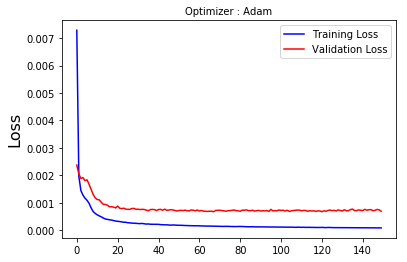

In [10]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [38]:
# 讀取測試資料集
imgs_test, point_tests = load_data(dirname = 'test.csv')
print("圖像資料:", imgs_test.shape, "\n關鍵點資料:", point_tests.shape)

圖像資料: (1783, 96, 96) 
關鍵點資料: (1783, 1)


In [12]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

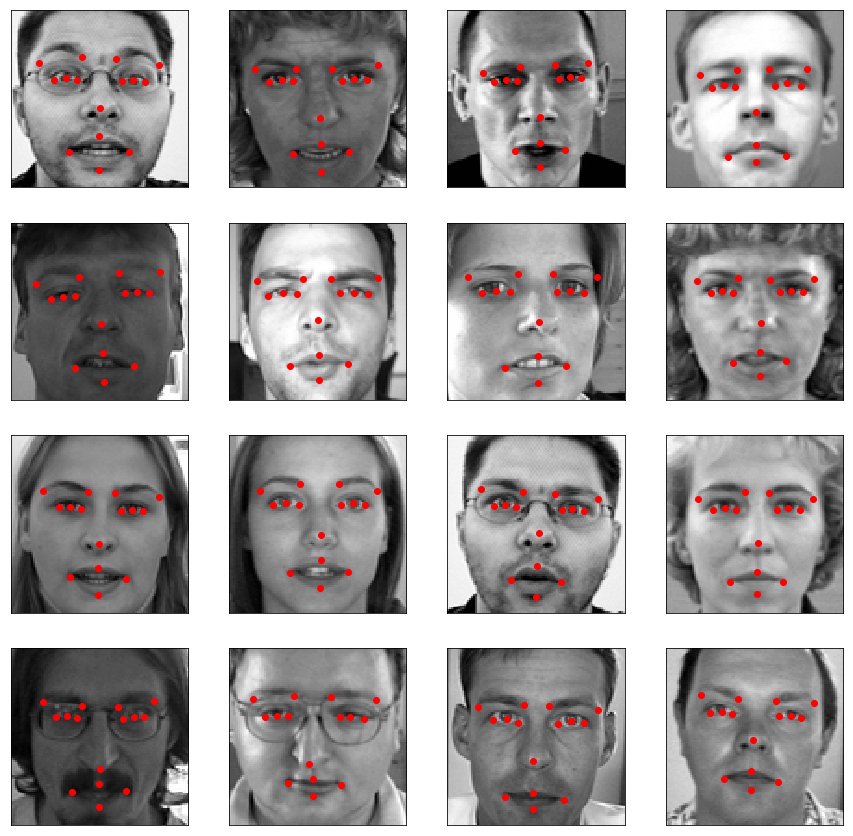

In [13]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [27]:
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [40]:
# Your code
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 2,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)

train_X = imgs_train.reshape(-1, 96, 96, 1)
training_set = train_datagen.flow(train_X, points_train,batch_size = 32)

model_with_augment.fit_generator(training_set, steps_per_epoch = len(train_X) // 32, nb_epoch = 20, callbacks=[checkpoint, hist], shuffle=True, validation_data=(train_X, points_train))

Epoch 1/20
 7/66 [==>...........................] - ETA: 1s - loss: 5.1670e-04

c:\users\seankang\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
c:\users\seankang\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=66, callbacks=[<keras.ca..., shuffle=True, validation_data=(array([[[..., epochs=20)`
  


66/66 [==============================] - 2s 27ms/step - loss: 5.1954e-04 - val_loss: 5.6361e-04

Epoch 00001: val_loss improved from inf to 0.00056, saving model to best_weights.h5
Epoch 2/20
66/66 [==============================] - 1s 23ms/step - loss: 5.2786e-04 - val_loss: 5.3797e-04

Epoch 00002: val_loss improved from 0.00056 to 0.00054, saving model to best_weights.h5
Epoch 3/20
66/66 [==============================] - 1s 22ms/step - loss: 5.1559e-04 - val_loss: 5.4502e-04

Epoch 00003: val_loss did not improve from 0.00054
Epoch 4/20
66/66 [==============================] - 1s 22ms/step - loss: 5.1993e-04 - val_loss: 5.0263e-04

Epoch 00004: val_loss improved from 0.00054 to 0.00050, saving model to best_weights.h5
Epoch 5/20
66/66 [==============================] - 1s 22ms/step - loss: 5.0887e-04 - val_loss: 5.0713e-04

Epoch 00005: val_loss did not improve from 0.00050
Epoch 6/20
66/66 [==============================] - 1s 22ms/step - loss: 5.1233e-04 - val_loss: 5.1210e-04

E

TypeError: 'History' object is not subscriptable

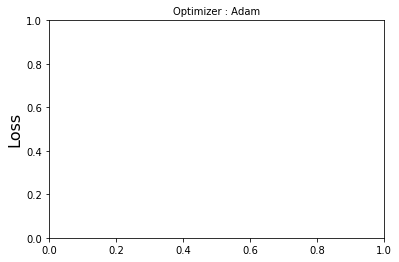

In [41]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_with_augment.history['loss'], color='b', label='Training Loss')
plt.plot(model_with_augment.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

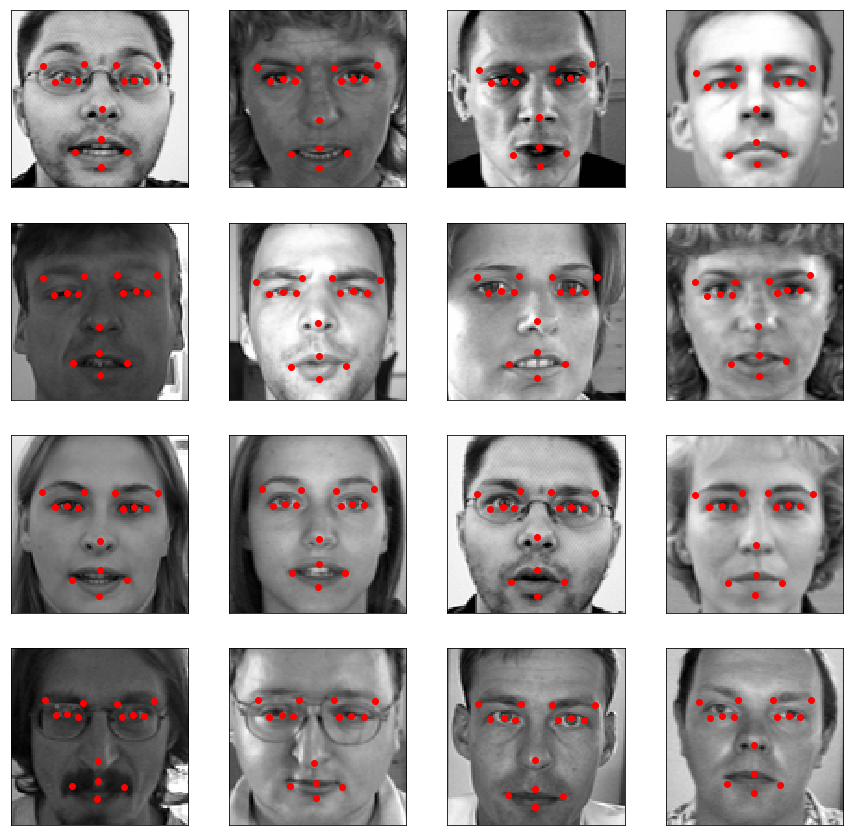

In [42]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [39]:
point_tests[0]

array([-0.48958334], dtype=float32)